In [1]:
import os
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# This is for the Cluster

Going to test my new algorithm on the cluster. 

/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (11,12,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


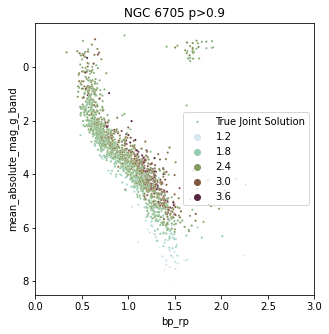

In [2]:
os.chdir("Data")
cluster_df=pd.read_csv('cluster_members_final.csv')
os.chdir("../")


probability='p3'
f, axes = plt.subplots(1, 1)
f.set_figheight(5)
f.set_figwidth(5)

cluster_df=cluster_df[cluster_df['phot_bp_mean_flux_error']<1000].reset_index(drop=True)

scatter=cluster_df[cluster_df[probability]>0.9]


sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter['rgeo'],s=5,ax=axes,label='True Joint Solution',color='b', palette="ch:r=1,l=1.0")
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.xlim(0,3)
plt.show()


scatter=scatter[scatter['rgeo']>=1.8].reset_index(drop=True)
scatter=scatter[scatter['rgeo']<=2.5].reset_index(drop=True)
#scatter=scatter[scatter['bp_rp']<=1.6].reset_index(drop=True)

orig_scatter=scatter

orig_scatter['rgeo']=scatter['rgeo'].median() #still assuming everything at the same distance
#set the main distance.
orig_scatter['rgeo']=2.0

cluster_df=scatter

In [3]:
cluster_df=cluster_df[['ra','dec','parallax','phot_g_mean_mag','phot_g_mean_flux','phot_rp_mean_flux','phot_bp_mean_flux','phot_bp_mean_mag','phot_rp_mean_mag','bp_rp','mean_absolute_mag_g_band','ra_error','dec_error','parallax_error','phot_g_mean_flux_error','phot_bp_mean_flux_error','phot_rp_mean_flux_error']].reset_index(drop=True)
cluster_df


,ra,dec,parallax,phot_g_mean_mag,phot_g_mean_flux,phot_rp_mean_flux,phot_bp_mean_flux,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,mean_absolute_mag_g_band,ra_error,dec_error,parallax_error,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error
0,282.605871,-6.285981,0.507387,16.404120,5.167716e+03,3876.549346,2425.859397,16.876379,15.776782,1.099597,4.856261,0.049640,0.053262,0.068056,3.639983,10.207194,14.392979
1,282.610660,-6.223920,0.414973,15.952048,7.836598e+03,5993.184109,3729.496588,16.409416,15.303751,1.105665,4.090620,0.042647,0.041917,0.053403,4.474360,15.521529,8.868863
2,282.610679,-6.250028,0.464578,16.118809,6.720840e+03,5265.982076,3198.065088,16.576324,15.444197,1.132128,4.479413,0.045167,0.044909,0.052555,3.836132,10.380806,18.499730
3,282.615905,-6.195400,0.455174,16.738075,3.799412e+03,3552.040656,1709.063662,17.256647,15.871700,1.384947,4.786609,0.064142,0.066674,0.092999,4.374199,9.564557,21.343086
4,282.617394,-6.285022,0.386008,14.585701,2.758459e+04,17640.015588,15755.160439,14.844985,14.131648,0.713337,2.684100,0.021657,0.020979,0.025863,10.341982,28.872372,83.859900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,282.792623,-6.051856,0.424239,13.486980,7.588484e+04,53535.371005,38981.029432,13.861409,12.926293,0.935116,1.804319,0.016018,0.016901,0.021350,21.492193,38.411700,44.480198
1097,282.840875,-6.043056,0.533869,16.632505,4.187401e+03,3402.451865,1810.603897,17.193983,15.918415,1.275568,5.241502,0.064591,0.069871,0.086673,3.368146,15.695131,20.524431
1098,282.844474,-6.035441,0.555500,17.378784,2.105878e+03,1859.903861,834.630940,18.034805,16.574170,1.460636,5.682174,0.087949,0.103732,0.129928,2.685649,8.458553,20.671124
1099,282.856958,-6.023364,0.436901,10.448225,1.246398e+06,888703.772511,633674.511865,10.833877,9.876003,0.957873,-1.190251,0.013677,0.013188,0.015801,297.194850,543.663600,344.572200


# Errors as per Gaia recommendations for the Photometric effects

In [4]:
cluster_df['phot_g_mean_mag_error']=np.sqrt(((2.5/np.log(10))*cluster_df['phot_g_mean_flux_error']/cluster_df['phot_g_mean_flux'])**2+0.0027553202**2)
cluster_df['bp_error']=np.sqrt(((2.5/np.log(10))*cluster_df['phot_bp_mean_flux_error']/cluster_df['phot_bp_mean_flux'])**2+0.0037793818**2)
cluster_df['rp_error']=np.sqrt(((2.5/np.log(10))*cluster_df['phot_rp_mean_flux_error']/cluster_df['phot_rp_mean_flux'])**2+0.0027901700**2)
cluster_df['bp_rp_error']=np.sqrt(cluster_df['rp_error']**2+cluster_df['bp_error']**2)

# Feature scaling might be important 

However, we can (I think) just untransform before the likelihood is done. Provided Pytorch allows us to propegate backwards through a scaling operation. I suppose we can actually just do manual scaling using Pytorch operations for MinMaxScaler and that would be fine.

# Data format

(batch size, sequence length, input dimension)
LSTMs learn ? over a longer period of time so my distance data will be batch_size, 1, 1,.

Circular lstm kind of thing? Anyway for now we say the only long term memory that is needed is the distance. Ra and Dec is somehting there but thats a local correlation and I'll try include that in the error function


# Draw instances of each row.

We will draw instances from a Gaussian of each row to simulate the error in our data.

#### Prior on Distance

We will need some sort of prior on distances. In this problem our distances are fairly tuned so I will just invert the parallax as the distance.

(array([492., 453., 103.,  31.,  14.,   4.,   2.,   1.,   0.,   1.]),
 array([0.35212121, 0.42885778, 0.50559435, 0.58233092, 0.65906749,
        0.73580406, 0.81254063, 0.8892772 , 0.96601377, 1.04275034,
        1.11948691]),
 <BarContainer object of 10 artists>)

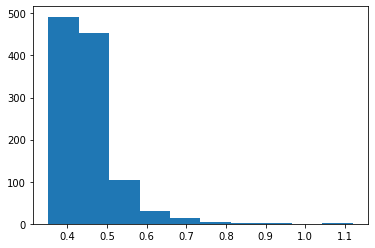

In [5]:
plt.hist(cluster_df['parallax'])

#### Normal distribution draws

Eventually should put in the cross correlations but for now isotropic.

In [6]:
mean_x=cluster_df[['ra','dec','parallax','phot_g_mean_mag','bp_rp']].to_numpy()
var_x=cluster_df[['ra_error','dec_error','parallax_error','phot_g_mean_mag_error','bp_rp_error']].to_numpy()**2

In [7]:
x_params=[]
x_var=[]
draw_size=32
for i in range (len(mean_x)):
    mu=mean_x[i]
    sig=np.diag(var_x[i])
    draws = np.random.multivariate_normal(mu, sig, size=draw_size)

    x_params.append(draws)
    x_var.append(np.tile(sig,(draw_size,1)))


In [8]:
x_params=np.array(x_params)
x_params=x_params.reshape((x_params.shape[0]*x_params.shape[1],x_params.shape[2]))


In [9]:
x_var=np.array(x_var)
x_var=x_var.reshape((x_var.shape[0]*x_var.shape[1],x_var.shape[2]))


In [10]:
x_params.shape

(35232, 5)

In [11]:
resampled_x=pd.DataFrame(data=x_params,columns=[['ra','dec','parallax','phot_g_mean_mag','bp_rp']])
resampled_err=pd.DataFrame(data=x_params,columns=[['ra_error','dec_error','parallax_error','phot_g_mean_mag_error','bp_rp_error']])
resampled_x['ra']=resampled_x['ra']%360
resampled_x['dec']=resampled_x['dec']%360

In [12]:
def mean_basolute_mag_g_band(selection_gaia):

    return selection_gaia['phot_g_mean_mag'].values+5*np.log10(selection_gaia['parallax'].values/1000)+5
    

resampled_x['G']=mean_basolute_mag_g_band(resampled_x)
cluster_df['G']=mean_basolute_mag_g_band(cluster_df)


/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_1569/4156368074.py:3: RuntimeWarning: invalid value encountered in log10
  return selection_gaia['phot_g_mean_mag'].values+5*np.log10(selection_gaia['parallax'].values/1000)+5


In [13]:
x_resample=pd.concat([resampled_x,resampled_err],axis=1)



In [14]:
x_resample

,ra,dec,parallax,phot_g_mean_mag,bp_rp,G,ra_error,dec_error,parallax_error,phot_g_mean_mag_error,bp_rp_error
0,282.607841,353.701268,0.543113,16.402420,1.107399,5.076873,282.607841,353.701268,0.543113,16.402420,1.107399
1,282.611148,353.720111,0.470468,16.403956,1.096347,4.766606,282.611148,353.720111,0.470468,16.403956,1.096347
2,282.537799,353.679292,0.528431,16.409072,1.100297,5.024015,282.537799,353.679292,0.528431,16.409072,1.100297
3,282.556258,353.661110,0.544469,16.402651,1.102609,5.082515,282.556258,353.661110,0.544469,16.402651,1.102609
4,282.607954,353.613366,0.529817,16.399693,1.117726,5.020324,282.607954,353.613366,0.529817,16.399693,1.117726
...,...,...,...,...,...,...,...,...,...,...,...
35227,282.793385,353.866343,0.393974,17.498671,1.658727,5.476010,282.793385,353.866343,0.393974,17.498671,1.658727
35228,282.904522,353.973889,0.274414,17.499652,1.653709,4.691686,282.904522,353.973889,0.274414,17.499652,1.653709
35229,282.754253,354.157045,0.308535,17.500275,1.626941,4.946798,282.754253,354.157045,0.308535,17.500275,1.626941
35230,282.722473,353.945776,0.509635,17.507240,1.656245,6.043536,282.722473,353.945776,0.509635,17.507240,1.656245


# Error understanding


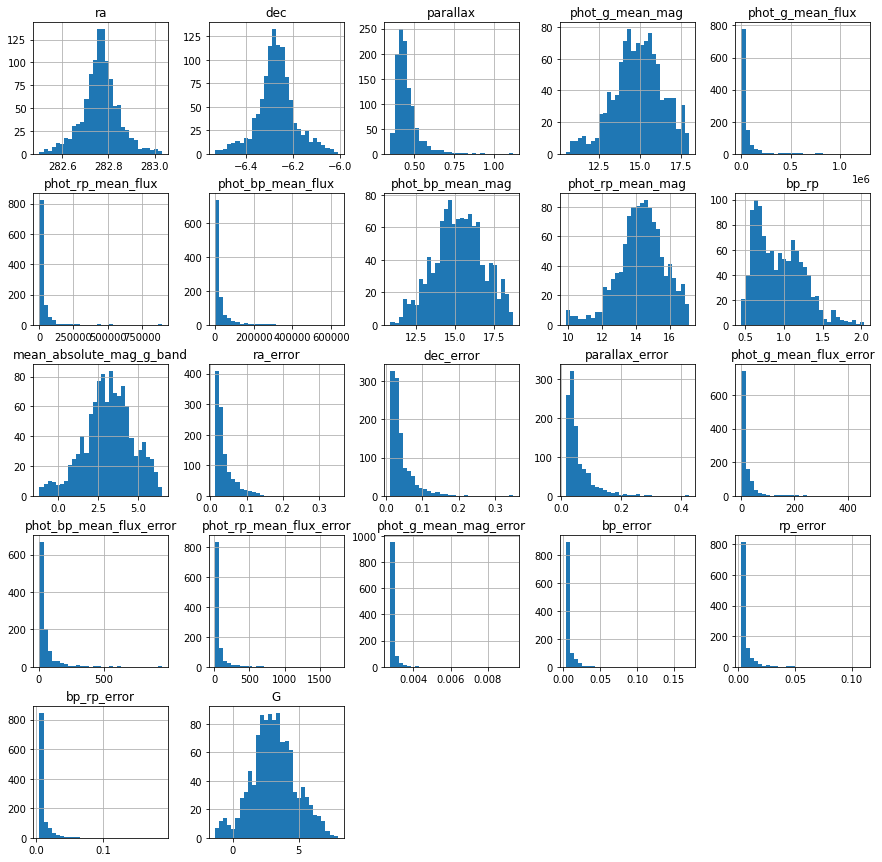

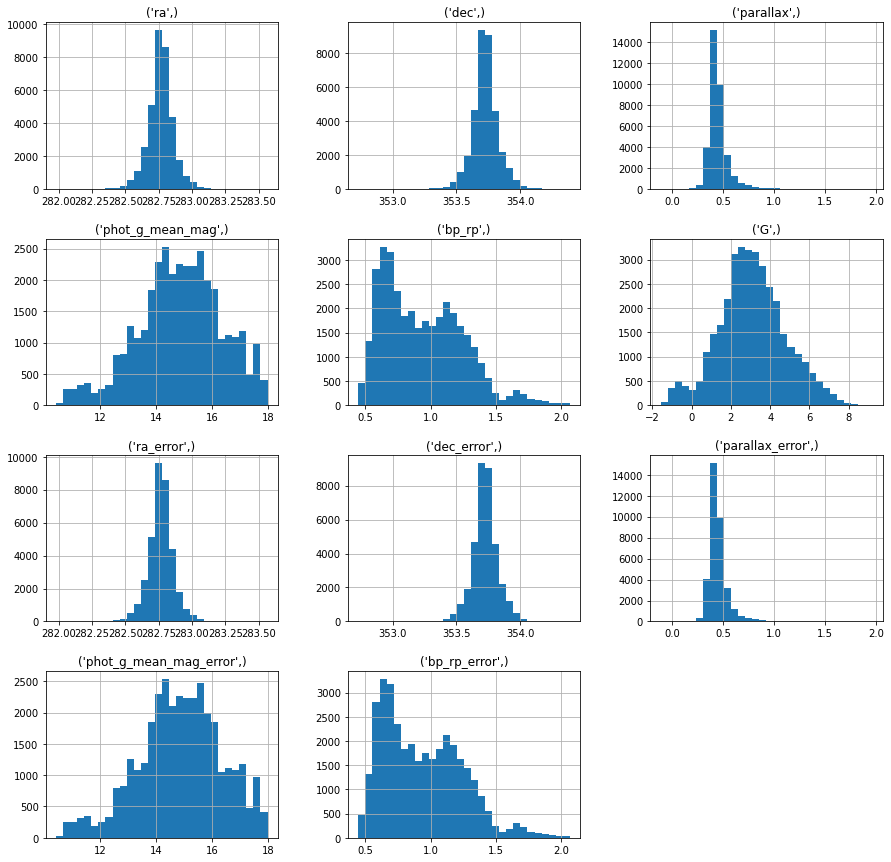

In [15]:
cluster_df.hist(bins=30, figsize=(15, 15))
x_resample.hist(bins=30, figsize=(15, 15))
plt.show()

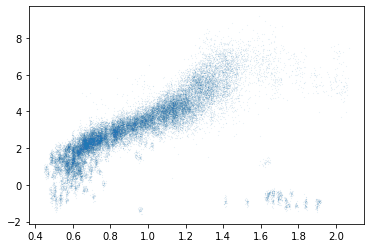

In [16]:
plt.scatter(x_resample['bp_rp'],x_resample['G'],s=0.001)

In [17]:
x_resample=x_resample.dropna().reset_index(drop=True)

# Isochrone preparing

The goal here is to derive the likelihood function easily.

In [18]:
import minimint

In [19]:
filters = ["Gaia_G_EDR3", "Gaia_BP_EDR3", 'Gaia_RP_EDR3']
ii = minimint.Interpolator(filters)


In [20]:
# Compute the isochrones
massgrid = 10*np.linspace(np.log10(0.1),np.log10(10), 1000)
logagegrid = [8.5,8.0,7.0]
fehgrid = [0.17,-1,-0.5]
dfs=[]
for feh in fehgrid:
    for lage in logagegrid:
        iso = pd.DataFrame(ii(massgrid, lage, feh))
        dfs.append(iso[iso['phase']==0])

# Fixed metalicity and age.

We will do for a fixed value that we are confident enough on. This is much easier as we only have one array.

In [21]:
# Compute the isochrones
massgrid = 10*np.linspace(np.log10(0.1),np.log10(10), 1000)
logagegrid = [8.0,8.1,8.3,8.5]
fehgrid = [0.17]
dfs=[]
for feh in fehgrid:
    for lage in logagegrid:
        iso = pd.DataFrame(ii(massgrid, lage, feh))
        dfs.append(iso[iso['phase']==0])

In [22]:
isochrone=dfs[0]

In [23]:
resampled_x

,ra,dec,parallax,phot_g_mean_mag,bp_rp,G
0,282.607841,353.701268,0.543113,16.402420,1.107399,5.076873
1,282.611148,353.720111,0.470468,16.403956,1.096347,4.766606
2,282.537799,353.679292,0.528431,16.409072,1.100297,5.024015
3,282.556258,353.661110,0.544469,16.402651,1.102609,5.082515
4,282.607954,353.613366,0.529817,16.399693,1.117726,5.020324
...,...,...,...,...,...,...
35227,282.793385,353.866343,0.393974,17.498671,1.658727,5.476010
35228,282.904522,353.973889,0.274414,17.499652,1.653709,4.691686
35229,282.754253,354.157045,0.308535,17.500275,1.626941,4.946798
35230,282.722473,353.945776,0.509635,17.507240,1.656245,6.043536


(8.0, -3.0)

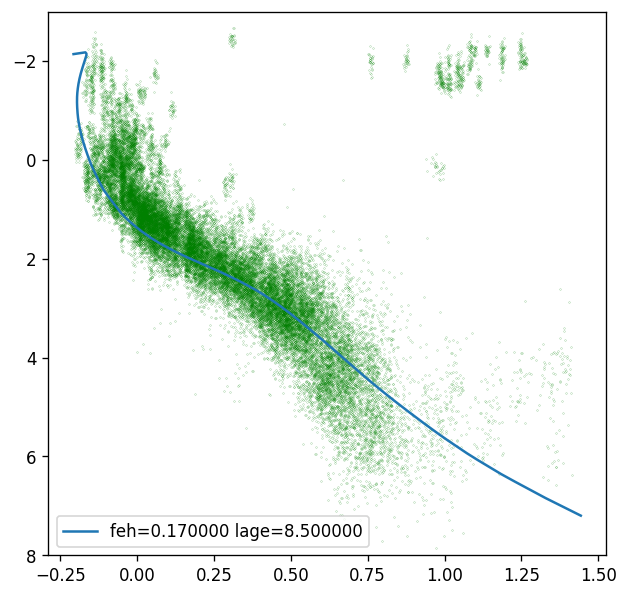

In [24]:
fig = plt.figure(figsize=(6, 6), dpi=120)

plt.plot(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3'], isochrone['Gaia_G_EDR3'],
                 label='feh=%f lage=%f' % (feh, lage))
plt.scatter(resampled_x['bp_rp']-0.65,resampled_x['G']-1.1,color='g',s=0.01)
plt.legend()

plt.ylim(8, -3)

# Build a CSV of all the possible isochrones.

In [25]:
massgrid = 10*np.linspace(np.log10(0.1),np.log10(10), 1000)
logagegrid = np.linspace(5,10.3,105)
fehgrid = np.linspace(-4,0.5,90)
dfs=[]
for feh in fehgrid:
    for lage in logagegrid:
        iso = pd.DataFrame(ii(massgrid, lage, feh))
        dfs.append(iso[iso['phase']==0].reset_index(drop=True))
        

In [26]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

# This is what I shall use for the prior

In [27]:
def isochrone_selector(feh,age):
    if(feh<-4 or feh>0.5):
        raise NotImplementedError
    if(age<5 or age>10.3):
        raise NotImplementedError
    else:
        logagegrid = np.linspace(5,10.3,105)
        fehgrid = np.linspace(-4,0.5,90)
        feh,feh_idx=find_nearest(fehgrid,feh)
        age,age_idx=find_nearest(logagegrid,age)

        return feh_idx*len(logagegrid)+age_idx
    

    
dfs[isochrone_selector(0,7)]

,logg,logteff,logl,mass,logage,feh,phase,Gaia_G_EDR3,Gaia_RP_EDR3,Gaia_BP_EDR3
0,4.306232,3.957463,1.206873,1.951952,6.9875,-0.005618,0.0,1.807048,1.780733,1.821957
1,4.312345,3.959965,1.215199,1.971972,6.9875,-0.005618,0.0,1.795250,1.772886,1.808124
2,4.315787,3.962844,1.227662,1.991992,6.9875,-0.005618,0.0,1.774408,1.756686,1.784882
3,4.317896,3.966103,1.242932,2.012012,6.9875,-0.005618,0.0,1.747875,1.735454,1.755604
4,4.319444,3.969515,1.259330,2.032032,6.9875,-0.005618,0.0,1.720538,1.713007,1.725741
...,...,...,...,...,...,...,...,...,...,...
398,4.098805,4.384011,3.824594,9.919920,6.9875,-0.005618,0.0,-2.466935,-2.203730,-2.605261
399,4.097831,4.384380,3.827914,9.939940,6.9875,-0.005618,0.0,-2.473305,-2.209917,-2.611729
400,4.096860,4.384750,3.831231,9.959960,6.9875,-0.005618,0.0,-2.479669,-2.216097,-2.618190
401,4.095891,4.385120,3.834547,9.979980,6.9875,-0.005618,0.0,-2.486027,-2.222272,-2.624644


(20.0, -10.0)

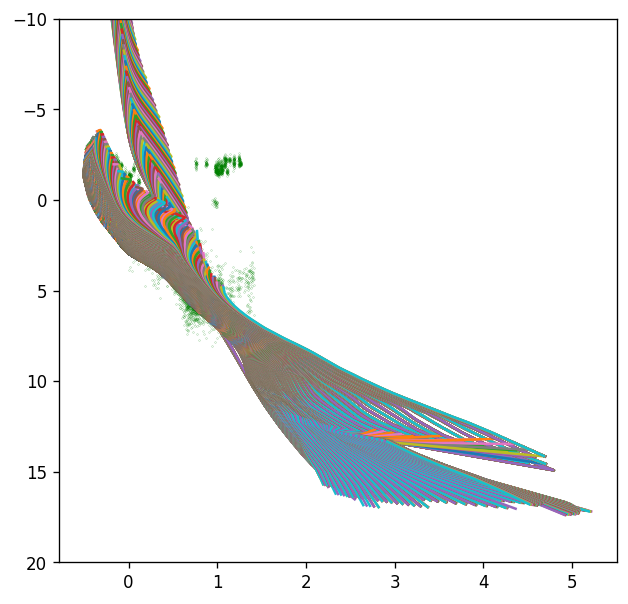

In [28]:
fig = plt.figure(figsize=(6, 6), dpi=120)
for isochrone in dfs:
    plt.plot(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3'], isochrone['Gaia_G_EDR3'],
                    )
    
    
plt.scatter(resampled_x['bp_rp']-0.65,resampled_x['G']-1.1,color='g',s=0.01)
plt.ylim(20, -10)

# Simultaneously do the tangent slopes for each isochrone.

In [29]:
for isochrone in dfs:
    p_slopes=[]
    isochrone['BPRP']=isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3']
    x=isochrone['BPRP']
    y=isochrone['Gaia_G_EDR3']
    
    for i in range(len(isochrone)-1):    
        dy=y[i+1]-y[i]
        dx=x[i+1]-x[i]
        p_slopes.append(-1*dx/dy)
    p_slopes.append(0)

    isochrone['p_slopes']=p_slopes
    isochrone['slopes']=-1/isochrone['p_slopes']

    high_c=[]
    low_c=[]
    for i in range(len(isochrone)-1):
        high_c.append(isochrone['Gaia_G_EDR3'][i+1] - isochrone['p_slopes'][i]*isochrone['BPRP'][i+1])
        low_c.append(isochrone['Gaia_G_EDR3'][i] - isochrone['p_slopes'][i]*isochrone['BPRP'][i])
    high_c.append(0)
    low_c.append(0)
    isochrone['low_c']=high_c #high c is low c oops
    isochrone['high_c']=low_c
    isochrone=isochrone[:-2]
    

# So given our data sample we can actually compute the likelihood before we do any learning.

In [30]:
i=3
x=(cluster_df['mean_absolute_mag_g_band']-cluster_df['bp_rp']*isochrone['p_slopes'][i]<=isochrone['high_c'][i]) #in correct region lowere bound
y=(isochrone['low_c'][i]<=cluster_df['mean_absolute_mag_g_band']-cluster_df['bp_rp']*isochrone['p_slopes'][i])  #in correct region upper bound
    

# This is the block tensor

Here we are creating a tensor(nsamples,nfeatures, copy size) where the dataframe has been copied in the z direction the length of the isochrone, this is because it will speed up the computation of the perpendicular. Morover, the isochrone has been copied in the first axis the number of times equal to the lenght of the number of samples. 

# Need a column finder function

In [31]:
def column_index(name):
    if name in cluster_df.columns:
        return np.where(np.array(cluster_df.columns)==name)[0][0]
    else:
        return np.where(np.array(dfs[0].columns)==name)[0][0] +len(cluster_df.columns)

In [32]:
import numpy as np
np.float64(-10.00)/0

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_1569/147731456.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  np.float64(-10.00)/0


-inf

# Decondstructing the cube

In [50]:
import torch
tens=[]
for isochrone in dfs:
    isoc=torch.tensor(isochrone.values).reshape((1,isochrone.shape[1],isochrone.shape[0]))
    tens.append(isoc)

rows=cluster_df.values
rows_ten=torch.tensor(rows)
rows_ten=rows_ten.reshape((rows_ten.shape[0],rows_ten.shape[1],1))


(array([1005., 2292.,  998.,  672.,  597.,  552.,  573.,  597.,  853.,
        1311.]),
 array([  1. ,  46.6,  92.2, 137.8, 183.4, 229. , 274.6, 320.2, 365.8,
        411.4, 457. ]),
 <BarContainer object of 10 artists>)

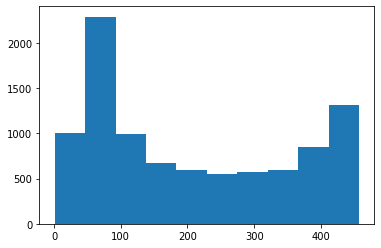

In [46]:
plt.hist(tens)

In [40]:
rows_ten.shape
#isoc.shape

torch.Size([1101, 22, 1])

In [ ]:
'''
import torch

collection_tensors=[]
for isochrone in dfs[1:2]:
    rows=cluster_df.values
    rows_ten=torch.tensor(rows)
    rows_ten=rows_ten.reshape((rows_ten.shape[0],rows_ten.shape[1],1))
    rows_ten=rows_ten.repeat(1,1,len(isochrone))

    isoc=torch.tensor(isochrone.values).reshape((1,isochrone.shape[1],isochrone.shape[0])).repeat(len(rows_ten),1,1)

    final=torch.cat((rows_ten,isoc),1)

    collection_tensors.append(final)
'''





# New method

In [ ]:
(torch.tensor(isochrone.values).element_size()*torch.tensor(isochrone.values).nelement()/1e9)*1000

0.00468

# Still need to send the G forward using parallax, at the moment distance doesnt depend on it

In [ ]:
x.reshape(x.shape[0],1,x.shape[1]).repeat(1,1,(isochrone).shape[-1]).shape

AttributeError: 'Series' object has no attribute 'reshape'

In [ ]:
isochrone=collection_tensors[0]
#x.shape
#e=torch.tensor([i for i in range(92)]).repeat(len(x),1)
#x[:,column_index('G'),:]+e
truth_1=(isochrone[:,column_index('G'),:]-isochrone[:,column_index('bp_rp'),:]*isochrone[:,column_index('p_slopes'),:]<=isochrone[:,column_index('high_c'),:])
truth_1=truth_1.reshape(truth_1.shape[0],1,truth_1.shape[1])

truth_2=(isochrone[:,column_index('low_c'),:]<=isochrone[:,column_index('G'),:]-isochrone[:,column_index('bp_rp'),:]*isochrone[:,column_index('p_slopes'),:])
truth_2=truth_2.reshape(truth_2.shape[0],1,truth_2.shape[1])
truth=truth_1*truth_2



3/(truth_1*truth_2)[0][0]

x=((1/torch.sqrt(1+isochrone[:,column_index('slopes'),:]**2))*(isochrone[:,column_index('G'),:]-isochrone[:,column_index('bp_rp'),:]*isochrone[:,column_index('slopes'),:]-isochrone[:,column_index('Gaia_G_EDR3'),:] + isochrone[:,column_index('slopes'),:]*isochrone[:,column_index('BPRP'),:]))
idx=torch.argmin(torch.abs(x/truth.reshape(x.shape)),1)
idx.shape
x=x.gather(1,idx.view(-1,1))
#error needs to be corrected
x_err=(1/(1+isochrone[:,column_index('slopes'),:]**2))*isochrone[:,column_index('phot_g_mean_mag_error'),:]**2+(isochrone[:,column_index('slopes'),:]*isochrone[:,column_index('bp_rp_error'),:])**2
x_err=x_err.gather(1,idx.view(-1,1))

isochrone=torch.cat((isochrone,x.reshape(x.shape[0],1,x.shape[1]).repeat(1,1,(isochrone).shape[-1]),x_err.reshape(x_err.shape[0],1,x_err.shape[1]).repeat(1,1,(isochrone).shape[-1])),1)

#((1/(1+isochrone['slopes'][i]**2))*test['phot_g_mean_mag_error']**2+(isochrone['slopes'][i]*test['bp_rp_error'])**2)

In [ ]:
x.shape

torch.Size([1101, 1])

# Vae Star Introduction

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

device='mps'

torch.backends.mps.is_available()


class encoder(nn.Module): #q(z|x)
    def __init__(self,input_dim,hidden_dims,z_dim):
        super().__init__()

        # need shapes
        self.input_dim=1
        self.n_layers=1
        self.lstm_hidden_dim=5

        self.z_dim=z_dim

        #need to take averages over z

        #the shape will be (batch_size,sequencelength=1,input_dim=1)
        self.dist_lstm=nn.LSTM(self.input_dim,self.lstm_hidden_dim,self.n_layers,batch_first=True)
        self.lstm_activation=nn.Tanh()

        self.input_dense=nn.Linear(in_features=input_dim,out_features=hidden_dims[0])
        self.hidden_dense=nn.Linear(in_features=hidden_dims[0],out_features=hidden_dims[1])
        self.input_activation=nn.ReLU()
        self.hidden_activation=nn.ReLU()

        self.concat_dense=nn.Linear(in_features=hidden_dims[1]+self.lstm_hidden_dim,out_features=z_dim*2)
        self.z_activation=nn.ReLU() #this will mean that extinction cant be negative (this is actually a part of the prior i suppose), could also just do linear


        self.N_ext=torch.distributions.Normal(0,1) #prior on extinction
        self.N_ext.loc=self.N_ext.loc.mps()
        self.N_ext.scale=self.N_ext.scale.mps()


        self.N_feh=torch.distributions.Normal(0,1) #prior feh, this may? need to be a uniform distribution
        self.N_feh.loc=self.N_feh.loc.mps()
        self.N_feh.scale=self.N_feh.scale.mps()

        self.N_age=torch.distributions.Normal(0,1) #prior on age, this will need to be a uniform distribution
        self.N_age.loc=self.N_age.loc.mps()
        self.N_age.scale=self.N_age.scale.mps()
        
    def forward(self, x):
        x_dist=x[:,-1]
        x_not_dist=x[:,:-1] # the last element in each row is the actual distance, and so we need to figure out what to do about the nans
        
        #everything but distance channel
        x_not_dist=self.input_activation(self.input_dense(x_not_dist))
        x_not_dist=self.hidden_activation(self.hidden_dense(x_not_dist))

        # distance channel LSTM
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #internal state
        # Propagate input through LSTM
        x_dist, (hn,cn) =self.lstm_activation(self.dist_lstm(x_dist.reshape(x_dist[0],1,x_dist[1])),(h_0,c_0))

        #concatenate channel
        x=torch.concat([x_not_dist,x_dist.reshape(x_dist.shape[0],x_dist.shape[2])],axis=1)
        output=self.concat_dense(x)

        z_mu=output[:,:self.z_dim]
        z_sigma=torch.exp(output[:,self.z_dim:])

        #sample a z value now
        
        z_ext=self.z_activation(z_mu[:,:2])+self.z_activation(z_sigma[:,:2])*self.N_ext.sample(z_mu[:,:2].shape)
        z_feh=z_mu[:,2]+z_sigma[:,2]*self.N_feh.sample(z_mu[:,2].shape)
        z_age=z_mu[:,3]+z_sigma[:,3]*self.N_age.sample(z_mu[:,3].shape)
        
        return z_ext,z_feh,z_age


class decoder(nn.Module):
    def __init__(self,z_dim):
        super(decoder,self).__init__()
        
    def forward(self,z_ext,z_feh,z_age,all_isochrones):
        
        # should i have a log scale on the age or will it know it
        #NEED TO STACK ALL OF THE ISOCHRONES AND WILL MAKE EAZ

        isochrone=all_isochrones[isochrone_selector(z_feh,z_age)] #can i apply this that easy or does a lot need to be changed to make it more tensor frienly

            isoc=torch.tensor(isochrone.values).reshape((1,isochrone.shape[1],isochrone.shape[0])).repeat(len(rows_ten),1,1)

        final=torch.cat((rows_ten,isoc),1)
        #now we need to do row by row the calculation we did before in the cube.
        # find out where the extinction needs to be added to or taken away from in the cluster_df
        # im going to let the normal prior say everything about the z values, and take away the implementation error.

        # the next is very specific to my isochrone file df i created
        isochrone[:,column_index('G'),:]+z_ext[:,:,0]
        isochrone[:,column_index('bp_rp'),:]+z_ext[:,:,1] #might neesd to be changed

        truth_1=(isochrone[:,column_index('G'),:]-isochrone[:,column_index('bp_rp'),:]*isochrone[:,column_index('p_slopes'),:]<=isochrone[:,column_index('high_c'),:])
        truth_1=truth_1.reshape(truth_1.shape[0],1,truth_1.shape[1])

        truth_2=(isochrone[:,column_index('low_c'),:]<=isochrone[:,column_index('G'),:]-isochrone[:,column_index('bp_rp'),:]*isochrone[:,column_index('p_slopes'),:])
        truth_2=truth_2.reshape(truth_2.shape[0],1,truth_2.shape[1])
        truth=truth_1*truth_2


        x=((1/torch.sqrt(1+isochrone[:,column_index('slopes'),:]**2))*(isochrone[:,column_index('G'),:]-isochrone[:,column_index('bp_rp'),:]*isochrone[:,column_index('slopes'),:]-isochrone[:,column_index('Gaia_G_EDR3'),:] + isochrone[:,column_index('slopes'),:]*isochrone[:,column_index('BPRP'),:]))
        idx=torch.argmin(torch.abs(x/truth.reshape(x.shape)),1)
        idx.shape
        x=x.gather(1,idx.view(-1,1))
        #error needs to be corrected
        x_err=(1/(1+isochrone[:,column_index('slopes'),:]**2))*isochrone[:,column_index('phot_g_mean_mag_error'),:]**2+(isochrone[:,column_index('slopes'),:]*isochrone[:,column_index('bp_rp_error'),:])**2
        x_err=x_err.gather(1,idx.view(-1,1))

        isochrone=torch.cat((isochrone,x.reshape(x.shape[0],1,x.shape[1]).repeat(1,1,(isochrone).shape[-1]),x_err.reshape(x_err.shape[0],1,x_err.shape[1]).repeat(1,1,(isochrone).shape[-1])),1)

                
        dist=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros_like(x),torch.eye(len(x))+torch.diag(x_err**2))

        log_prob=dist.log_prob(x)
        return log_prob,z_ext,z_feh,z_age
        


class VaeStar

        



        



In [ ]:
all_likelihood=[]

#'this is to reset the loop'
x=orig_scatter['bp_rp']
y=orig_scatter['mean_absolute_mag_g_band']


scaler=StandardScaler(with_mean=False,with_std=False)


#i got them the wrong way around but the code works
#------------------------------------------------------------
#scaler tranformation
scaler=StandardScaler(with_mean=False,with_std=False)

#------------------------------------------------------------
#should it be true or false on the mean
#this just takes the final two values away, stops any things with zero slopes at the end.
#------------------------------------------------------------



tests=[]
err_means=[]
for i in range(len(isochrone)-1):

    
    scatter['y_'+str(i)]=np.nan
    scatter['y_'+str(i)+'_err']=np.nan
    x=(scatter['mean_absolute_mag_g_band']-scatter['bp_rp']*isochrone['p_slopes'][i]<=isochrone['high_c'][i]) #in correct region lowere bound
    y=(isochrone['low_c'][i]<=scatter['mean_absolute_mag_g_band']-scatter['bp_rp']*isochrone['p_slopes'][i])  #in correct region upper bound
    
    #------------------------------------------------------------
    # Here we get rid of all of the points which have been selected by the algo so far and parse ones 
    test=scatter[x]
    
    test=test[y]
    
    #------------------------------------------------------------
    #We find the random variable mean and variance which correponds to the distance from the line on the isochrone
    #------------------------------------------------------------

    #y proj is the projection onto the colour
    
    if(len(test)>0):
        test['yproj']=((1/np.sqrt(1+isochrone['slopes'][i]**2))*(test['mean_absolute_mag_g_band']-test['bp_rp']*isochrone['slopes'][i]-isochrone['Gaia_G_DR2Rev'][i] + isochrone['slopes'][i]*isochrone['BPRP'][i]))*(1/np.sqrt(1+isochrone['p_slopes'][i]**2))
        test['yproj_err']=((1/(1+isochrone['slopes'][i]**2))*test['phot_g_mean_mag_error']**2+(isochrone['slopes'][i]*test['bp_rp_error'])**2)*(1/(1+isochrone['p_slopes'][i]**2))

        test['y']=((1/np.sqrt(1+isochrone['slopes'][i]**2))*(test['mean_absolute_mag_g_band']-test['bp_rp']*isochrone['slopes'][i]-isochrone['Gaia_G_DR2Rev'][i] + isochrone['slopes'][i]*isochrone['BPRP'][i]))
        test['y_err']=((1/(1+isochrone['slopes'][i]**2))*test['phot_g_mean_mag_error']**2+(isochrone['slopes'][i]*test['bp_rp_error'])**2)
        #------------------------------------------------------------                
        
        #we will then choose the minimum y based on this
        #are these dataframes matching up


        scatter.loc[scatter.index.isin(test.index), 'y_'+str(i)] = test['y'].values
        scatter.loc[scatter.index.isin(test.index), 'y_'+str(i)+'_err']=test['y_err'].values#

        #orig_scatter[orig_scatter.index.isin(test.index)]['y_'+str(i)]=test['y'].values#.replace('nan',0.0).fillna(0.0).astype(float).values
        #orig_scatter[orig_scatter.index.isin(test.index)]['y_'+str(i)+'_err']=test['y_err'].values#.replace('nan',0.0).fillna(0.0).astype(float).values
    else:
        continue
    
        
columns=['y_'+str(i) for i in range(len(isochrone)-1)]
scatter['y']=scatter[columns].min(axis=1)

scatter=scatter.dropna(subset=['y'])
val=scatter[columns].idxmin(axis=1).astype(str)+str('_err')
scatter['y_err']=scatter.lookup(val.index,val.values)

flat_test=scatter['y'].values
flat_testerr=scatter['y_err'].values

#gmm_GES=XDGMM(2).fit(flat_test.reshape(len(flat_test),1),flat_testerr.reshape(len(flat_test),1,1),R=np.array([1.0]*len(flat_testerr)).reshape(len(flat_testerr),1,1))
#prob_ges=gmm_GES.logL(flat_test.reshape(len(flat_test),1),flat_testerr.reshape(len(flat_test),1,1),R=np.array([1.0]*len(flat_testerr)).reshape(len(flat_testerr),1,1))
#likelihood.append(prob_ges)
likelihood.append(np.abs(flat_test).sum())

    all_likelihood.append(np.array(likelihood))    



IndentationError: unexpected indent (4137257963.py, line 81)

In [ ]:
dfs[0]

,logg,logteff,logl,mass,logage,feh,phase,Gaia_BP_EDR3,Gaia_G_EDR3,Gaia_RP_EDR3,BPRP,p_slopes,slopes,low_c,high_c
0,3.606054,3.882052,1.972215,0.570571,5.0,-4.0,0.0,-0.079993,-0.176915,-0.361534,0.281541,-0.111193,8.993352,-0.639760,-0.145610
1,3.529762,3.894053,2.167015,0.590591,5.0,-4.0,0.0,-0.587594,-0.665031,-0.814859,0.227266,-0.111940,8.933318,-1.122006,-0.639590
2,3.454413,3.905965,2.360519,0.610611,5.0,-4.0,0.0,-1.082987,-1.141476,-1.256919,0.173932,-0.102682,9.738850,-1.594045,-1.123616
3,3.379368,3.917841,2.553578,0.630631,5.0,-4.0,0.0,-1.565238,-1.606996,-1.691370,0.126132,-0.085762,11.660219,-2.054079,-1.596179
4,3.305439,3.929584,2.744986,0.650651,5.0,-4.0,0.0,-2.033185,-2.061553,-2.120333,0.087148,-0.072286,13.833874,-2.503706,-2.055254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1.460875,4.280756,11.775707,2.292292,5.0,-4.0,0.0,-22.929439,-22.824211,-22.638107,-0.291331,-0.065082,15.365239,-23.159513,-22.843172
87,1.428523,4.295493,11.937360,2.312312,5.0,-4.0,0.0,-23.249711,-23.139218,-22.937878,-0.311833,-0.047828,20.908356,-23.477788,-23.154132
88,1.396171,4.310229,12.099012,2.332332,5.0,-4.0,0.0,-23.577219,-23.462135,-23.249942,-0.327277,-0.037844,26.424422,-23.802668,-23.474521
89,1.363819,4.324966,12.260665,2.352352,5.0,-4.0,0.0,-23.909082,-23.789814,-23.569404,-0.339678,-0.037844,26.424442,-24.130816,-23.802668


# VAE star